In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import parfit.parfit as pf  # Hyperparameter optimization

In [2]:
DATAPATH = '../data/'

# Embeddings and/or activations created by underlying models
USEL_FILE = 'embed_corpus_201907252332.csv'   
LSTM_FILE = 'activ_corpus_201907301209.csv'
POOL_FILE = 'pool_activ_corpus_201907301317.csv'

# Identifiers indicating which model to use for preprocessing steps
MODEL_TYPE_ID = 'lrp3'              
MODEL_TIMESTAMP = '201907301454'

In [3]:
# Read the embeddings and/or activations created by the three underlying models
# (and labels, which are the same for all three)
def read_data(fn):
    return(pd.read_csv(DATAPATH+fn, index_col=['id','time'], parse_dates=['time']))

df_usel = read_data(USEL_FILE)
df_lstm = read_data(LSTM_FILE)
df_pool = read_data(POOL_FILE)

# Remove duplicate index values to avoid merge problems
def remove_dups(df):
    return(df[~df.index.duplicated()])

df_usel = remove_dups(df_usel)
df_lstm = remove_dups(df_lstm)
df_pool = remove_dups(df_pool)

In [4]:
df_usel.head().iloc[:,:7]  # Left side of the head of the first file

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1703564846,2019-05-21 17:50:48+00:00,True,-66830,11661,-32570,-37820,-21984,74883
211806644,2019-05-21 17:50:48+00:00,False,-8995,3055,29928,52060,-82077,-17550
971515498411241472,2019-05-21 17:50:48+00:00,False,-61137,-60111,-37451,7108,34800,76067
2430359987,2019-05-21 17:50:49+00:00,False,3522,-19081,-16808,-70327,-26245,35645
2860188236,2019-05-21 17:50:49+00:00,True,7274,-9629,-10552,37276,-4486,39685


In [5]:
df_usel.shape, df_lstm.shape, df_pool.shape

((191260, 513), (191260, 241), (191260, 401))

In [6]:
# Optimized relative scaling factors for the three underlying models
scaledown_lstm = 7
scaledown_pool = 700

In [7]:
# Combine embeddings (or activations) from the three underlying feature-generating models
df_full = df_usel.join(df_lstm.drop(['male'],axis=1)/scaledown_lstm, rsuffix='lstm').join(
                       df_pool.drop(['male'],axis=1)/scaledown_pool, rsuffix='pool')
df_full.shape

(191260, 1153)

In [8]:
df_full.head().iloc[:,:7]  # Left side of the head of the combined data

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1703564846,2019-05-21 17:50:48+00:00,True,-66830,11661,-32570,-37820,-21984,74883
211806644,2019-05-21 17:50:48+00:00,False,-8995,3055,29928,52060,-82077,-17550
971515498411241472,2019-05-21 17:50:48+00:00,False,-61137,-60111,-37451,7108,34800,76067
2430359987,2019-05-21 17:50:49+00:00,False,3522,-19081,-16808,-70327,-26245,35645
2860188236,2019-05-21 17:50:49+00:00,True,7274,-9629,-10552,37276,-4486,39685


In [9]:
df_full.head().iloc[:,-7:]  # Right side of the head of the combined data

,,activ393,activ394,activ395,activ396,activ397,activ398,activ399
id,time,,,,,,,
1703564846,2019-05-21 17:50:48+00:00,-30.754286,-6.478571,-56.102857,4.024286,21.878571,0.444286,16.240000
211806644,2019-05-21 17:50:48+00:00,-27.994286,-10.384286,-28.867143,30.332857,131.617143,3.244286,-6.287143
971515498411241472,2019-05-21 17:50:48+00:00,-26.020000,-57.055714,-2.537143,33.070000,-41.317143,-9.217143,-30.445714
2430359987,2019-05-21 17:50:49+00:00,54.497143,24.624286,25.578571,21.907143,-40.584286,38.207143,-2.301429
2860188236,2019-05-21 17:50:49+00:00,-1.365714,-32.227143,-34.104286,42.405714,34.660000,-4.630000,23.307143


In [10]:
df_full.tail().iloc[:,:7]  # Left side of the tail of the combined data

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
970657219,2019-07-06 17:01:02+00:00,False,56109,-28802,11365,-60410,-91626,23367
1144347639200256000,2019-07-06 17:01:03+00:00,False,58664,32438,-36149,6159,45262,45370
2540538534,2019-07-06 17:01:04+00:00,False,58248,11779,-29026,35231,-21648,13774
19669474,2019-07-06 17:01:05+00:00,True,27264,18738,4244,-12185,-101862,50964
891741719225565185,2019-07-06 17:01:05+00:00,False,23637,41496,9690,-10819,-7783,6373


In [11]:
# Verifty that data are in order of time
timediffs = df_full.reset_index().time.diff()
timediffs.min(), timediffs.max()

(Timedelta('0 days 00:00:00'), Timedelta('5 days 06:21:14'))

In [12]:
# Load the optimized model that includes preprocessing steps fit on the original training data
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + MODEL_TIMESTAMP + '.joblib'
base_model = joblib.load(model_path)

In [13]:
# Perform PCA using original fit
X_raw_full = df_full.drop(['male'],axis=1).values / 1e6
pca = base_model.named_steps['pca']
X_pca_full = pca.transform(X_raw_full)
X_pca_full.shape

(191260, 25)

In [14]:
# Calculate quadratic features
poly = base_model.named_steps['poly']
X_poly_full = poly.transform(X_pca_full)
X_poly_full.shape

(191260, 351)

In [15]:
# Labels
y_full = df_full.male.values
y_full.shape

(191260,)

In [16]:
# Split data (hypotehtically) into burn-in, validation, and test sections
val_frac = .2
test_frac = .2

burn_frac = 1 - val_frac - test_frac
burn_in = int(burn_frac*len(y_full))
val_end = burn_in + int(val_frac*len(y_full))
burn_in, val_end

(114756, 153008)

In [17]:
# Minibatch generator

# Yields 'train' and 'test' batches at each iteration.
# Each 'test' batch then becomes the 'train' batch for the subsequent iteration.

# Also performs (constant) scaling of features.

def iter_minibatches(X, y, chunksize, scale):
    # Provide chunks one by one
    train_start = 0
    test_start = train_start + chunksize
    while test_start < len(y):
        train_rows = range(train_start, train_start+chunksize)
        test_rows = range(test_start, min(test_start+chunksize,len(y)))
        X_train = X[train_rows]*scale  
        y_train = y[train_rows]
        X_test = X[test_rows]*scale
        y_test = y[test_rows]
        yield X_train, y_train, X_test, y_test
        train_start += chunksize
        test_start += chunksize

In [18]:
# A Scikit-learn-style class to encapsulate the model for online learning
# Useful for optimizing hyperparameters

# Unlike most Scikit-learn models, the fitting and prediction has to be done on a whole data set at once.
# The usual train/test split and cross-validation concepts don't apply.
# Instead, the parameter 'val_start' indicates the section of data whose results will be evaluated
#    for hyperparameter selection and/or model testing.
# The value of 'val_start' should be selected to allow a sufficeint amount of burn in
#    for the online learning process.
# Note that *all* the predictions produced by an object of this class will be *out of batch*, 
#    in constrast to the usual Scikit-learn approach
#    where predictions can be either for the training set (in fold) or the test set (out of fold),

class OnlineSGD:

    def __init__(self, scale, batchsize, steps_per_batch, alpha, rand, val_start):
        self.scale = scale
        self.batchsize = batchsize
        self.steps_per_batch = steps_per_batch
        self.alpha = alpha
        self.rand = rand
        self.val_start = val_start
        self.result = None
        self.prob_cutoff = .5

    def show_params(self):
        print('scale = ', self.scale)
        print('batchsize = ', self.batchsize)
        print('steps_per_batch = ', self.steps_per_batch)
        print('alpha = ', self.alpha)
        print('rand = ', self.rand)
        print('val_start = ', self.val_start)
        self.result = None    
        
    def fit(self, X, y):
        # Since this is online learning, we don't use a separate test set
        # Just keep calculating and saving out-of-batch predictions for the subsequent batch
        # The 'fitted model' is just a collection of those predictions
        batcherator = iter_minibatches(X, y, chunksize=self.batchsize, scale=self.scale)
        model = SGDClassifier(loss='log', alpha=self.alpha, random_state=self.rand)
        y_pred = self.batchsize*[np.nan]
        for X_train, y_train, X_test, y_test in batcherator:
            for _ in range(self.steps_per_batch):
                model.partial_fit(X_train, y_train, [0,1])
            y_pred += model.predict_proba(X_test)[:,1].tolist()
        self.result = np.array(y_pred)
        return(self)
        
    def predict_proba(self, X):
        # This just returns the already calculated out-of-batch predictions for the part of the data
        #   that has been designated for validation. (The X argument is just a placeholder.)
        return(self.result[self.val_start:])
    
    def predict(self, X):
        return(self.predict_proba(X) > self.prob_cutoff)
    

In [19]:
# Initial grid of hyperparameter values to optimized
grid = {
    'scale': [.5, 1, 2],
    'batchsize': [1000, 2000, 4000],
    'steps_per_batch': [1, 5],
    'alpha': [1e-3, 3e-3, 1e-2],
    'rand': [0],            # This is a random seed
    'val_start': [burn_in]  # This should be a fixed value
}

In [20]:
# Intial hyperparameter optimization:  optimize all hyperparameters coarsely
for rand in range(4):  # Run the optimization 4 times with different seeds
    grid['rand'] = [rand]
    paramGrid = ParameterGrid(grid)
    bestModel, bestScore, allModels, allScores = \
    pf.bestFit(OnlineSGD, paramGrid,
               X_poly_full[:val_end], y_full[:val_end], X_poly_full[burn_in:val_end], y_full[burn_in:val_end], 
               metric = accuracy_score, greater_is_better=True,
               scoreLabel = "accuracy")
    print(bestModel, bestScore)
    bestModel.show_params()

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:   24.9s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:   28.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:   29.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Too many dimensions to plot.
<__main__.OnlineSGD object at 0x7f8666343940> 0.6230523894175468
scale =  1
batchsize =  2000
steps_per_batch =  5
alpha =  0.003
rand =  0
val_start =  114756
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:   17.7s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:   20.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:   22.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Too many dimensions to plot.
<__main__.OnlineSGD object at 0x7f86662640b8> 0.6233660985046533
scale =  2
batchsize =  1000
steps_per_batch =  5
alpha =  0.001
rand =  1
val_start =  114756
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:   18.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:   21.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:   22.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Too many dimensions to plot.
<__main__.OnlineSGD object at 0x7f8664912d68> 0.6233138136568023
scale =  2
batchsize =  2000
steps_per_batch =  5
alpha =  0.003
rand =  2
val_start =  114756
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:   17.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:   20.7s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:   22.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------
Too many dimensions to plot.
<__main__.OnlineSGD object at 0x7f86648a5e10> 0.6236013803199832
scale =  1
batchsize =  4000
steps_per_batch =  5
alpha =  0.001
rand =  3
val_start =  114756


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    6.0s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.7s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    8.5s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   11.6s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   12.5s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   13.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


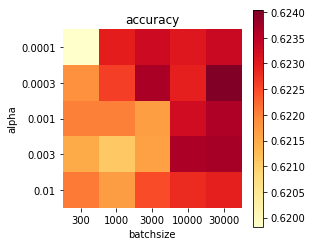

<__main__.OnlineSGD object at 0x7f866485c908> 0.6240458015267175
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    6.8s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.9s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.0s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   12.3s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   13.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


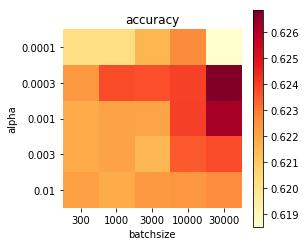

<__main__.OnlineSGD object at 0x7f866477d898> 0.626843040886751
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    6.6s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    7.3s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    8.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   12.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   13.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


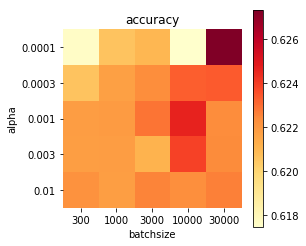

<__main__.OnlineSGD object at 0x7f866464e4e0> 0.6273397469413364
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    7.2s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    7.5s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.3s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   13.1s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   13.4s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


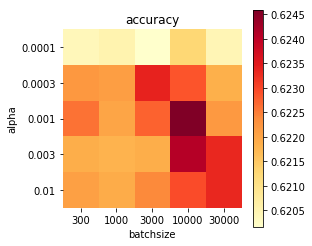

<__main__.OnlineSGD object at 0x7f86645a9080> 0.624594792429154


In [21]:
# Re-optimize along two dimensions (batchsize, alpha), using values suggested by the original optimization
grid = {
    'scale': [1.5],
    'batchsize': [300, 1000, 3000, 10000, 30000],
    'steps_per_batch': [5],
    'alpha': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    'rand': [rand],
    'val_start': [burn_in]
}
for rand in range(4):
    grid['rand'] = [rand]
    paramGrid = ParameterGrid(grid)
    bestModel, bestScore, allModels, allScores = \
    pf.bestFit(OnlineSGD, paramGrid,
               X_poly_full[:val_end], y_full[:val_end], X_poly_full[burn_in:val_end], y_full[burn_in:val_end], 
               metric = accuracy_score, greater_is_better=True,
               scoreLabel = "accuracy")
    print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.5s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    6.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    6.3s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    6.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   10.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


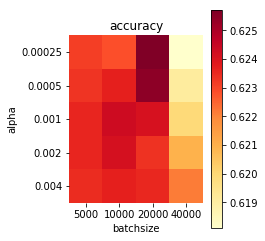

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


<__main__.OnlineSGD object at 0x7f86644db748> 0.625692774234027
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    6.2s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    6.4s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    6.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   11.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


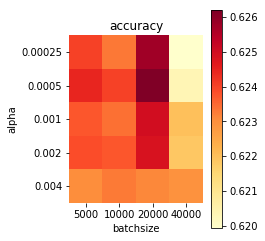

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


<__main__.OnlineSGD object at 0x7f866442a320> 0.6261894802886123
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    5.8s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    6.3s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    6.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    7.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   10.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


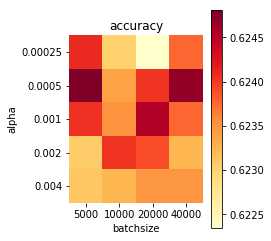

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


<__main__.OnlineSGD object at 0x7f8664365320> 0.6248039318205584
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    6.1s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    6.5s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    6.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    7.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   10.5s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   11.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


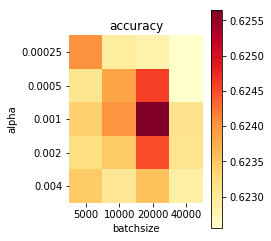

<__main__.OnlineSGD object at 0x7f86642a52b0> 0.6256404893861759


In [22]:
# Re-optimize batchsize and alpha again, using ranges suggested by the first re-optimization
grid = {
    'scale': [1.5],
    'batchsize': [5000, 10000, 20000, 40000],
    'steps_per_batch': [5],
    'alpha': [2.5e-4, 5e-4, 1e-3, 2e-3, 4e-3],
    'rand': [rand],
    'val_start': [burn_in]
}
for rand in range(4,8):
    grid['rand'] = [rand]
    paramGrid = ParameterGrid(grid)
    bestModel, bestScore, allModels, allScores = \
    pf.bestFit(OnlineSGD, paramGrid,
               X_poly_full[:val_end], y_full[:val_end], X_poly_full[burn_in:val_end], y_full[burn_in:val_end], 
               metric = accuracy_score, greater_is_better=True,
               scoreLabel = "accuracy")
    print(bestModel, bestScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    5.3s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    7.4s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.4s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   11.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   13.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


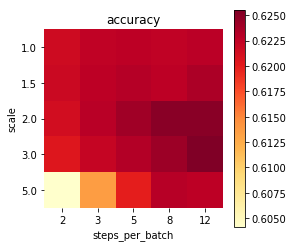

<__main__.OnlineSGD object at 0x7f86641f7470> 0.6255359196904737
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    5.3s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.7s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.3s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   12.0s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   12.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


-------------SCORING MODELS-------------


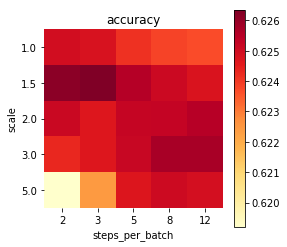

<__main__.OnlineSGD object at 0x7f86640dbc18> 0.6263463348321656
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    5.2s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    7.2s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.3s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   11.9s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   13.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   14.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


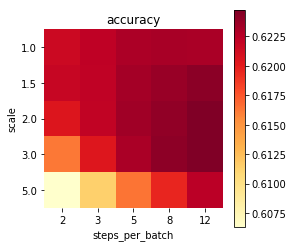

<__main__.OnlineSGD object at 0x7f865efc5fd0> 0.6247516469727074
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    5.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.9s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    9.6s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   11.9s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   12.9s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   13.9s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


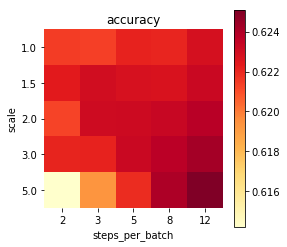

<__main__.OnlineSGD object at 0x7f865ef1bac8> 0.6250914984837395


In [23]:
# Optimize along two other dimensions (scale and steps_per_batch)
grid = {
    'scale': [1.0, 1.5, 2.0, 3.0, 5.0],
    'batchsize': [20000],
    'steps_per_batch': [2, 3, 5, 8, 12],
    'alpha': [8e-4],
    'rand': [rand],
    'val_start': [burn_in]
}
for rand in range(4):
    grid['rand'] = [rand]
    paramGrid = ParameterGrid(grid)
    bestModel, bestScore, allModels, allScores = \
    pf.bestFit(OnlineSGD, paramGrid,
               X_poly_full[:val_end], y_full[:val_end], X_poly_full[burn_in:val_end], y_full[burn_in:val_end], 
               metric = accuracy_score, greater_is_better=True,
               scoreLabel = "accuracy")
    print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   10.0s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   11.7s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   16.8s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   19.9s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   22.0s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   24.1s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   25.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


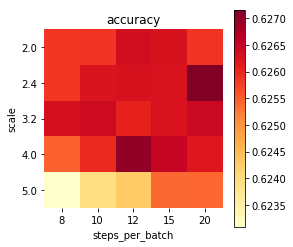

<__main__.OnlineSGD object at 0x7f865eeb95f8> 0.6271567499738576
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   10.1s remaining:   40.3s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   12.0s remaining:   25.5s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   17.4s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   19.9s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   21.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   23.9s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   25.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


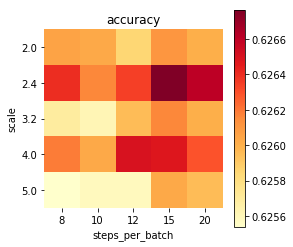

<__main__.OnlineSGD object at 0x7f865ed90898> 0.6267646136149744
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   10.5s remaining:   41.9s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   12.9s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   17.1s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   20.4s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   22.3s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   24.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   26.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


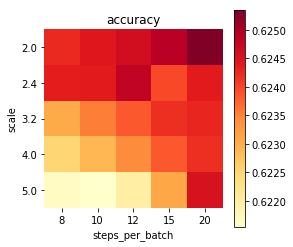

<__main__.OnlineSGD object at 0x7f865ecea1d0> 0.6253529227229949
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:    9.7s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   12.4s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   17.1s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   19.3s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   21.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   23.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   25.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


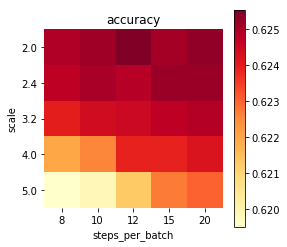

<__main__.OnlineSGD object at 0x7f865ec0ab00> 0.6255359196904737


In [24]:
# Re-optimize scale and steps_per_batch, using values suggested by previous optimization
grid = {
    'scale': [2.0, 2.4, 3.2, 4.0, 5.0],
    'batchsize': [20000],
    'steps_per_batch': [8, 10, 12, 15, 20],
    'alpha': [8e-4],
    'rand': [rand],
    'val_start': [burn_in]
}
for rand in range(4, 8):
    grid['rand'] = [rand]
    paramGrid = ParameterGrid(grid)
    bestModel, bestScore, allModels, allScores = \
    pf.bestFit(OnlineSGD, paramGrid,
               X_poly_full[:val_end], y_full[:val_end], X_poly_full[burn_in:val_end], y_full[burn_in:val_end], 
               metric = accuracy_score, greater_is_better=True,
               scoreLabel = "accuracy")
    print(bestModel, bestScore)

In [25]:
# Test section results for best model
for rand in range(4):
    sgd = OnlineSGD(3.5, 20000, 20, 8e-4, rand, val_end)
    sgd.fit(X_poly_full, y_full)
    print(accuracy_score(y_full[val_end:], sgd.predict(_)))

0.6227909651782914
0.622294259123706
0.6232092439611001
0.6222681166997804


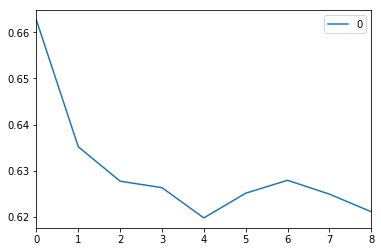

In [26]:
alpha = 8e-4;  steps_per_batch = 20;  batchsize = 20000;  scale = 3.5 
rand = 0
batcherator = iter_minibatches(X_poly_full, y_full, chunksize=batchsize, scale=scale)
model = SGDClassifier(loss='log', alpha=alpha, random_state=rand)
progress = []
for X_train, y_train, X_test, y_test in batcherator:
    for _ in range(steps_per_batch):
        model.partial_fit(X_train, y_train, [0,1])
    y_predicted = model.predict_proba(X_test)[:,1]
    progress.append(accuracy_score(y_test, y_predicted>.5))
pd.DataFrame(progress).plot()
plt.show()

The model performs better on the early part (first two batches), because that is the original training and validation data, on which the features were optimized.  After that the performance seems more or less flat, and in particular, there is no trend of improvement and deterioration.  That means the overall procedure is working well.  If performance were improving over time, that would indicate that we still don't have enough data to get optimal results.  If performance were deteriorating over time, that would indicate that the features are becoming "stale" and that the full underlying models that generate those features would need to be re-fit frequently.  Flat performance suggests that we do have enough data and that the features are robust to changes over time.